# Notation
- $x$: $[n \times d]$ predictor
- $y$: $[n \times 1]$ response
- $(x_\textrm{train}, y_\textrm{train})$: train data
- $(x_\textrm{test}, y_\textrm{test})$: test data

# Motivation
- assume a prior distribution over the response $y \sim \textrm{MVNormal}(0, \Sigma)$
    - each component of $y$ corresponds to one dimension of this multivariate distribution
    - $\Sigma(y_i, y_j)$ depends on the distance between $(x_i, x_j)$
    - $(x_i, x_j)$ are close -> correlation approaches $1$
    - $(x_i, x_j)$ are far -> correlation (typically) approaches $0$
- $y$ consists of some observard values $(y_\textrm{train})$ and some unobserved $(y_\textrm{test})$
    - what we're really interested in is the distribution $y_\textrm{test} | y_\textrm{train}$
    - in other words, we must condition the prior distribution $(y_\textrm{train}, y_\textrm{test})$ on $y_\textrm{train}$
    - conveniently, a MVNormal distribution after conditioning is still a MVNormal distribution (over the remaining variables)
- GPs as linear regression
    - assume we're fitting a liner model in some feature space $\phi$
    - we have a $N(0, \sigma^2)$ prior over the model weights
    - if we sample set of $x_i$, the $y_i$ have a joint $\text{MVNormal}(0, \Sigma)$ distribution
    - the choice of the feature space $\phi$ determines the covariance matrix $\Sigma$
- advantages over linear regression
    - in linear regression, we are specifying the prior at a relatively low level (eg polynomial degree)
    - in GPs, we can specify a high level prior (eg the function is smooth and periodic)

# Conditioning

Assume that $(y_\textrm{train}, y_\textrm{test})$ has the joint distribution:
$$p(y_\textrm{train}, y_\textrm{test}) = N\left(\begin{bmatrix} a \\ b \end{bmatrix}, \begin{bmatrix} A & B \\ B^T & C \end{bmatrix} \right)$$

Then the conditional distribution is:
$$p(y_\textrm{test} | y_\textrm{train}) = N(a + BC^{-1}(y_\textrm{train} - b), A - BC^{-1}B^T)$$

# Kernels (distance measure)

- the covariance matrix $\Sigma$ is defined by the kernel, eg RBF, periodic, linear...
    - scale parameter $\sigma$ defines the amplitude of the data
    - length parameter $l$ defines how quickly the correlation between points decreases, as their distance increases
        - $l$ is small $\Rightarrow$ high model flexibility
    - under RBF, the closer the points are in $L_2$, the higher their correlation
    - under a perodic kernel, the correlation does not monotonically depend on $L_2$ distance

# Noisy observations
- assume that $f$ is a GP: $f \sim \text{GP}$
- our data has mean given by the GP plus some gaussian observation noise $\epsilon$: $y = f + \epsilon$
- *because* this likelihood is gaussian, we can work with it analytically --> just add an identity matrix to the covariance matrix of training data $A$
- if we leave the covariance matrix of test data unchanged, we are fitting the distribution of the mean of the test points; if the do add an identity matrix to the covariance matrix of the test points, we get the distribution for observations

# Marginal likelihood
- by definition, the marginal likelihood is simply the likelihood of the observed data under the prior predictive distribution $N(0, \Sigma)$

# Is it Bayesian?
- yes (if we assume a fixed prior), but not in the classical sense
- typically, we assume a prior over parameters, then update the prior using a likelihood to get a posterior
- here, instead
    - the are no parameters (GPs are non-parametric)
    - we assume a prior joint distribution over $(y_\textrm{train}, y_\textrm{test})$
    - we condition the prior on $y_\textrm{train}$
    - the result is a distribution $y_\textrm{test} | y_\textrm{train}$
- but if we optimize the prior to maximize marignal likelihood, our model stops being Bayesian! (see below)

# Fitting hyperparameters
- each set of hyperparameters corresponds to one specific prior
- typically, we select those hyperparameters that maximize the log marginal likelihood(LML)
    - this can be done using SGD
    - note: this is a non-covex problem
    - there might be multiple sets of hyperparameters that correspond to different regimes
    - eg: (high flexibility + low noise) vs (low flexibility + high noise) vs ("hybrid": medium flexibility + medium noise)
    - if we have enough data, the GP will typically converge to the "hybrid" regime (which is what we want)
    - it would be possible to instead consider a prior over hyperparameters and run MCMC to get generate samples from the posterior over hyperparameters
        - this is computationally expensive
        - if we can assume that the posterior would be concentrated around one set of hyperparameters anyway, we can approximate the posterior using that as a point estimate
- maximizing LML makes sense if priors that support complex models assign them a low probability mass
    - for example, in linear regression, we might have
        - a prior that supports only simple 1d models, hence assigns them high mass (because the domain is small)
        - a prior that supports complex high-level polynomial models, but assigns low mass to each model (because the domain is large)
        - (in this example, selecting the prior that maximizes marignal likelihood might be ok)
    - now imagine instead that
        - we have milions of different priors
        - each prior only supports a very narrow range of complex models
        - each prior supports a different complex model
        - in the limit
            - any possible model has some prior that supports it with probability mass close to 1
            - hence the marginal likelihood becomes equivalent to the likelihood (maximizing LML becomes equivalent to MLE)
            - as Pavel said, *"a likelihood for one model can always be seen as a marginal likelihood for another model"*
            - this limit might actually be practically achieved if eg the mean function is parametrized by a large neural network

# Hyperpriors
- in parametric models a hierarchical prior is always equivalent to the marginal prior over parameters [STAT31, slides 4/29]
- we can apply the same reasoning to GPs
    - a set of hyperparams corresponds to one specific MVNormal prior over the data y
    - having a prior over hyperparams induces some marginal prior over y – but this marginal prior is no longer Gaussian!
- hyperpriors in GPs are very useful (in contrast to standard parametric models)
    - in a parametric model, if we have large uncertainty over the params, we can set a vague prior
    - in GPs, any given prior makes a strong assumption about the data-generating process (ie it sets some specific length-scale, period, etc)
    - hence, it GPs, we must always consider a range of possible priors
    - afterwards, we must somehow performs inference over the hyperparameters
        - Bayesian approach: MCMC
        - non-Bayesian approach: maximize marginal likelihood

# Misc
- [bernoulli likelihood](https://www.jmlr.org/papers/volume6/kuss05a/kuss05a.pdf)

# Reading
- [The Gradient](https://thegradient.pub/gaussian-process-not-quite-for-dummies/) (my favorite, nice overview of kernels)
- [A Practical Guide to Gaussian Processes](https://infallible-thompson-49de36.netlify.app) (has great interactive demo)
- [Distill](https://distill.pub/2019/visual-exploration-gaussian-processes)
- [Gaussian processes with Jax in 80 lines](https://tpin.uk/posts/gaussian-processes-in-jax/)

Note: the entire notebook is based on [this article](https://thegradient.pub/gaussian-process-not-quite-for-dummies/) from *The Gradient*

# imports

In [1]:
import jax
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt

In [2]:
jax.config.update("jax_enable_x64", True)
%config InlineBackend.figure_format='retina'

# helper functions

In [3]:
def sample_mv_normal(key, mean, cov, shape, epsilon=1e-8):
    """
    like jax.random.multivariate_normal but with better numerical stability
    - when sampling from a multivariate normal, we have to perform cholesky decomposition of the covariance matrix
    - cholesky decomposition of a matrix requires that the matrix be positive definite
    - the RBF kernel is *strictly* positive definite but when we numerically approximate it,
      we might get tiny negative eigenvalues (ie its approximation is *not* positive definite)
    - to avoid numerical problems with the decomposition, it helps to add epsilon * identity matrix
    - based on: https://stats.stackexchange.com/a/386837/231402
    """
    z = jax.random.normal(key, shape=[*shape, *mean.shape])
    A = jnp.linalg.cholesky(cov + epsilon*jnp.eye(len(mean)))
    y = vmap(lambda z: A @ z + mean)(z)
    return y

# define kernels

In [4]:
def vectorize_kernel(kernel_fn):
    return vmap(vmap(kernel_fn, [None, 0]), [0, None])

@vectorize_kernel
def rbf_kernel(x1, x2):
    vertical_scale = 0.3
    horizontal_scale = 0.07
    d2 = ((x1 - x2)**2).sum()
    return vertical_scale**2 * jnp.exp(- 0.5 * d2 / horizontal_scale**2)

@vectorize_kernel
def laplace_kernel(x1, x2):
    vertical_scale = 0.3
    horizontal_scale = 0.6
    d = jnp.abs(x1 - x2).sum()
    return vertical_scale**2 * jnp.exp(- 0.5 * d / horizontal_scale**2)

@vectorize_kernel
def periodic_kernel(x1, x2):
    vertical_scale = 0.3
    horizontal_scale = 0.3
    period = 0.4
    d = jnp.sqrt(((x1 - x2)**2).sum())
    return vertical_scale**2 * jnp.exp(- 0.5 * jnp.sin(jnp.pi*d/period)**2 / horizontal_scale**2)

@vectorize_kernel
def linear_kernel(x1, x2):
    return jnp.dot(x1, x2)

def linear_rbf_kernel(x1, x2):
    return linear_kernel(x1, x2) + rbf_kernel(x1, x2)

In [5]:
# 2d test
x1 = jnp.ones([10, 2])
x2 = jnp.ones([20, 2])
kernel_fns = [rbf_kernel, laplace_kernel, periodic_kernel, linear_kernel, linear_rbf_kernel]
for kernel_fn in kernel_fns:
    K = kernel_fn(x1, x2)
    print(K.shape)

(10, 20)
(10, 20)
(10, 20)
(10, 20)
(10, 20)


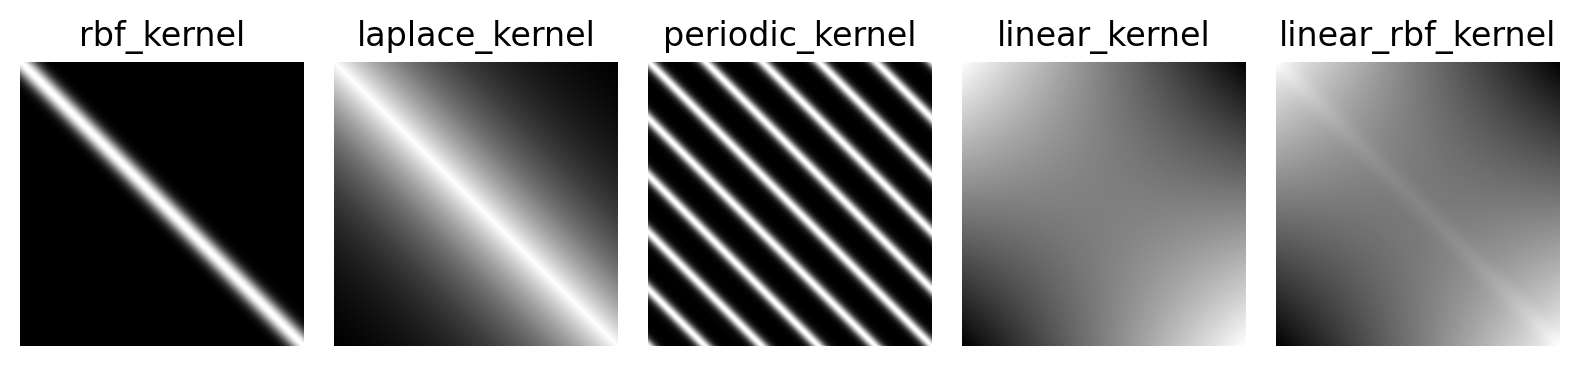

In [6]:
# plot kernel function
fig, axs = plt.subplots(1, len(kernel_fns), figsize=[8, 6])
x1 = jnp.linspace(-1, 1, 1_000)
x2 = jnp.linspace(-1, 1, 1_000)

for ax, kernel_fn in zip(axs, kernel_fns):
    ax.imshow(kernel_fn(x1, x2), cmap='gray')
    ax.set_title(kernel_fn.__name__)
    ax.axis('off')

plt.tight_layout()
plt.show()

# conditioning

In [7]:
def get_prior(x_test, kernel_fn):
    mean = jnp.zeros_like(x_test)
    cov = kernel_fn(x_test, x_test)
    return mean, cov

def get_posterior(x_train, x_test, y_train, kernel_fn, observation_noise_sd=0.05):
    A = kernel_fn(x_test, x_test)
    B = kernel_fn(x_test, x_train)
    C = kernel_fn(x_train, x_train) + observation_noise_sd**2 * jnp.eye(len(x_train))
    mean = B @ jnp.linalg.lstsq(C, y_train)[0]
    cov = A - B @ jnp.linalg.lstsq(C, B.T)[0]
    return mean, cov

# plots

In [8]:
def plot_gp(ax, x, mean, cov, samples):
    
    # plot mean ± sd
    sd = jnp.sqrt(cov.diagonal())
    ax.plot(x_test, mean)
    ax.fill_between(x_test, mean-2*sd, mean+2*sd, alpha=0.5)
    
    # plot samples
    for y_test in samples:
        ax.plot(x_test, y_test, c='black', ls='--', lw=1, alpha=0.7)

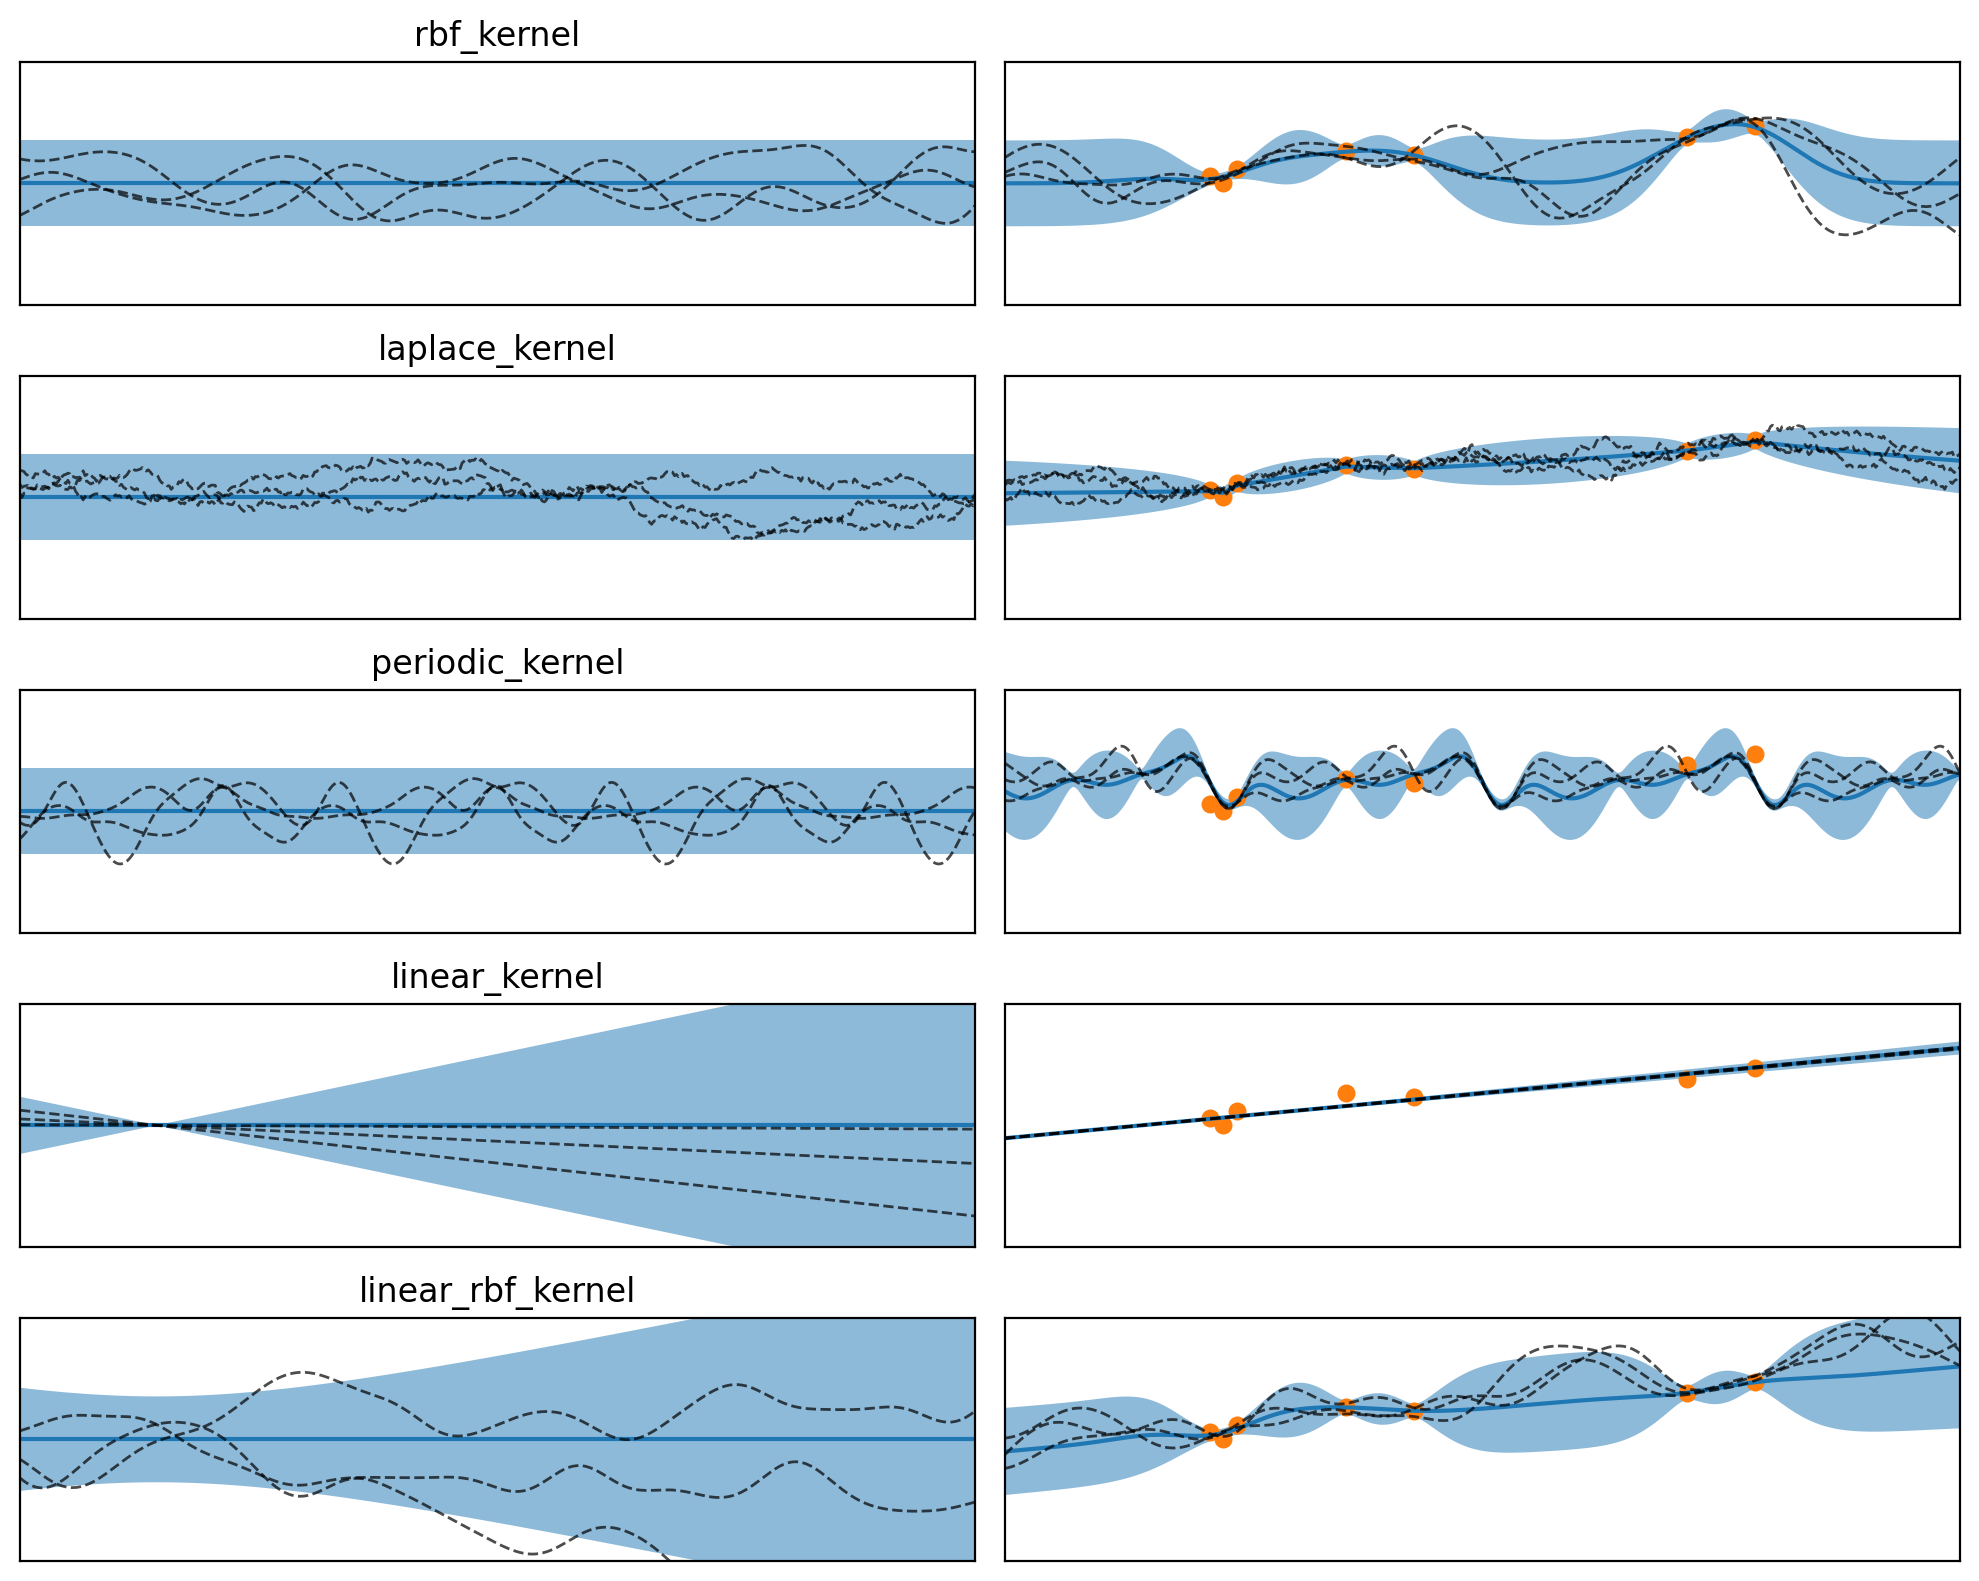

In [9]:
fig, axs = plt.subplots(len(kernel_fns), 2, figsize=[10, 8])

# set train and test data
x_train = jnp.array([ 0.10,  0.12,  0.14,  0.30,  0.40,  0.80,  0.90])
# y_train = jnp.array([-0.30,  0.10, -0.40,  0.00,  0.10,  0.70, -0.10])
y_train = jnp.array([0.10,  0.00, 0.20,  0.45,  0.40,  0.65, 0.8])
x_test = jnp.linspace(-0.2, 1.2, 500)

# plot each kernel
key = jax.random.PRNGKey(2)
for i, kernel_fn in enumerate(kernel_fns):
    key, key_prior, key_posterior = jax.random.split(key, 3)
    
    # compute prior
    mean, cov = get_prior(x_test, kernel_fn)
    
    # sample prior
    samples = sample_mv_normal(key_prior, mean, cov, [3])
    
    # plot prior
    plot_gp(axs[i, 0], x_test, mean, cov, samples)
    
    # compute posterior by conditioning on observations
    mean, cov = get_posterior(x_train, x_test, y_train, kernel_fn)
    
    # sample posterior
    samples = sample_mv_normal(key_posterior, mean, cov, [3])

    # plot posterior
    plot_gp(axs[i, 1], x_test, mean, cov, samples)
    axs[i, 1].scatter(x_train, y_train, s=30)
    axs[i, 0].set_title(kernel_fn.__name__)

# finish plot
for ax in axs.flatten():
    ax.set_xlim([-0.2, 1.2])
    ax.set_ylim([-1.7, 1.7])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
# plt.savefig('gp.pdf')
plt.show()